<div class="alert alert-block alert-warning">
Submit this notebook via Moodle!
</div>

In [1]:

# Core imports (pytest optional)
try:
    import pytest
except ImportError:
    pytest = None
import matplotlib.pyplot as plt
import numpy as np
from typing import Any, Dict, List

from bandits import RandomAgent, EpsilonGreedyAgent, UCBAgent, GradientBandit
from environments.recsys import RecsysEnvironment
from utils import experiment_factory, run_multi_seeds
from utils import plot_reward_band


In [2]:
# uncomment if ipynb is not installed
# !pip install ipynb

In [3]:

# import functions from previous notebook
try:
    from ipynb.fs.full.N1_basic import eg_select, eg_update, ucb_select, ucb_update, gb_select, gb_update
except Exception:
    # Fallback definitions (mirroring N1_basic solutions)
    from environments.base import State
    import numpy as np

    def eg_select(self, s: State) -> int:
        """Select an arm via E-greedy, initializing any new arms on the fly. Use argmax to select the greedy action; do not resolve tiebreaks via random selection."""
        if not isinstance(s, State): raise TypeError("s must be a State")
        available_ids = [a.id for a in s.actions]
        for a_id in available_ids:
            if a_id not in self.Q:
                self.Q[a_id] = self.initial_value
                self.N[a_id] = 0
        if float(self.rng.rand()) < self.epsilon:
            return int(self.rng.choice(available_ids))
        best_q = max(self.Q[a] for a in available_ids)
        for a_id in available_ids:
            if self.Q[a_id] == best_q:
                return int(a_id)

    def eg_update(self, arm_id: int, reward: float, s: State) -> None:
        """Update Q[arm_id] from observed reward"""
        if not isinstance(arm_id, int): raise TypeError("arm id must be int")
        if not isinstance(reward, float): raise TypeError("reward id must be float")
        if not isinstance(s, State): raise TypeError("s id must be State")
        if arm_id not in self.Q or any([a.id not in self.Q for a in s.actions]) or arm_id not in [a.id for a in s.actions]:
            raise ValueError(
                f"Unseen arm {arm_id}; call `select` before `update`."
            )
        self.N[arm_id] += 1
        if self.alpha is None:
            self.Q[arm_id] += (reward - self.Q[arm_id]) / self.N[arm_id]
        else:
            self.Q[arm_id] += self.alpha * (reward - self.Q[arm_id])
        self.t += 1

    def ucb_select(self, s: State) -> int:
        """Select arm maximizing UCB index; ensure each new arm is tried once."""
        if not isinstance(s, State): raise TypeError("s must be a State")
        available_ids = [a.id for a in s.actions]
        for a_id in available_ids:
            if a_id not in self.Q:
                self.Q[a_id] = self.initial_value
                self.N[a_id] = 0
        for a_id in available_ids:
            if self.N[a_id] == 0:
                return int(a_id)
        log_term = np.log(max(self.t, 1))
        best_arm = None
        best_idx = None
        for a_id in available_ids:
            bonus = self.c * np.sqrt(log_term / self.N[a_id])
            idx = self.Q[a_id] + bonus
            if best_idx is None or idx > best_idx:
                best_idx = idx
                best_arm = a_id
        return int(best_arm)

    def ucb_update(self, arm_id: int, reward: float, s: State) -> None:
        """Increment time, update counts, and apply sample-average value update."""
        if not isinstance(arm_id, int): raise TypeError("arm id must be int")
        if not isinstance(reward, float): raise TypeError("reward id must be float")
        if not isinstance(s, State): raise TypeError("s id must be State")
        if arm_id not in self.Q or any([a.id not in self.Q for a in s.actions]) or arm_id not in [a.id for a in s.actions]:
            raise ValueError(
                f"Unseen arm {arm_id}; call `select` before `update`."
            )
        self.t += 1
        self.N[arm_id] += 1
        self.Q[arm_id] += (reward - self.Q[arm_id]) / self.N[arm_id]

    def gb_select(self, s: State) -> int:
        """Sample an arm according to the softmax over preferences H[a]."""
        if not isinstance(s, State): raise TypeError("s must be a State")
        available_ids = [a.id for a in s.actions]
        for a_id in available_ids:
            if a_id not in self.H:
                self.H[a_id] = 0.0
        probs = self._softmax(available_ids)
        p_vec = [probs[a_id] for a_id in available_ids]
        return int(self.rng.choice(available_ids, p=p_vec))

    def gb_update(self, arm_id: int, reward: float, s: State) -> None:
        """Apply the preference gradient update using the current set of available arms."""
        if not isinstance(arm_id, int): raise TypeError("arm id must be int")
        if not isinstance(reward, float): raise TypeError("reward id must be float")
        if not isinstance(s, State): raise TypeError("s id must be State")
        if arm_id not in self.H or any([a.id not in self.H for a in s.actions]) or arm_id not in [a.id for a in s.actions]:
            raise ValueError(
                f"Unseen arm {arm_id}; call `select` before `update`."
            )
        available_ids = [a.id for a in s.actions]
        probs = self._softmax(available_ids)
        baseline = self.avg_reward
        for a_id in available_ids:
            indicator = 1.0 if a_id == arm_id else 0.0
            self.H[a_id] += self.alpha * (reward - baseline) * (indicator - probs[a_id])
        self.t += 1
        self.avg_reward += (reward - self.avg_reward) / self.t

# workaround if the ipynb import does not work for you:
#!jupyter nbconvert --to python N1_basic.ipynb
#from N1_basic import eg_select, eg_update, ucb_select, ucb_update, gb_select, gb_update

EpsilonGreedyAgent.select = eg_select
EpsilonGreedyAgent.update = eg_update
UCBAgent.select = ucb_select
UCBAgent.update = ucb_update
GradientBandit.select = gb_select
GradientBandit.update = gb_update


# **2. JKU News Lab (13 Points)**

The **JKU News Lab** is a simulated online news platform designed to study and evaluate algorithms for **personalized article recommendation**.  
It models a busy digital newsroom with approximately **30 user visits per minute** (similar to orf.at; source: ahrefs.com), where new articles are continuously published and older ones gradually lose relevance.

At any given moment, a pool of **six news articles** — curated by the editorial team — is displayed on the homepage.  
The agent’s goal is to **select the best article** from this limited set to feature in the **top-tier position**, thereby maximizing user engagement through clicks.


### **State (`WebsiteState`)**

Represents the current observable state of the environment at a given simulation step.

| Attribute | Type | Description |
|------------|------|-------------|
| `actions` | `List[Article]` | The current catalog of candidate articles available for recommendation. |
| `context` | `np.ndarray` | Contextual feature vector representing the current user. |
| `steps` | `int` | Number of recommendation steps taken so far since the simulation began. |
| `time_hours` | `float` | Current simulated time in hours since the start of the environment. |

### **Action (`Article`)**

Represents a candidate news article that can be recommended to users. Each article corresponds to an **arm** in the bandit setting.

| Attribute | Type | Description |
|------------|------|-------------|
| `id` | `int` | Unique identifier of the article. |
| `features` | `np.ndarray` | Embedding vector describing the article’s content and latent characteristics (e.g., topic representation). |
| `topic` | `int` | Identifier of the article’s main topic category. |
| `publisher` | `int` | Identifier of the article’s publisher or source. |
| `published_at` | `float` | Simulated publication timestamp (in hours). Used to model article freshness. |
| `base_popularity` | `float` | Latent base popularity or intrinsic appeal of the article, independent of user preferences. |

For now, we are only interested in the **article IDs**.  
In the next notebook, we will explore **personalized recommendations** that incorporate user features.


### **Interface**

The environment follows a standard **bandit-style interface**:

- `state()`: Returns the current `WebsiteState`, providing observable information for decision-making.  
- `step(article_id)`: Selects one of the available articles, returns simulated feedback (click or no click), and updates the environment state.


### **Hyperparameter Optimization**

Answer the following questions and perform **hyperparameter optimization** for the three bandit algorithms implemented earlier:

- `EpsilonGreedyAgent`
- `UCBAgent`
- `GradientBandit`

Each algorithm has its own section below, where you should experiment with suitable hyperparameter values (e.g., learning rate, exploration rate, confidence level, etc.) and evaluate their performance to determine the best configuration.  
After completing each experiment, briefly describe your **setup**, **results**, and **insights** below the corresponding cell.

### **Notes**

- Place your optimization code inside the **wrapper functions** provided (e.g., `your_epsilon_greedy_optimization`).  
- These wrappers ensure that the optimization code does **not run automatically** during autograding.  
- The variable `RUN_OPTIMIZATION` will be set automatically during evaluation — you do **not** need to modify it.  
- The provided code is a placeholder; feel free to create your own visualizations that better illustrate the chosen optimization criterion.

In [4]:
# nothing to do for you here; keep this, we'll set it to False during automatic grading
RUN_OPTIMIZATION = True

#### **Task 2.1.1. Optimization Criterion (1 Point)**

**Question:** What will be your optimization criterion?  
Provide a **single-sentence explanation** describing the metric or objective you will use to compare agent performance.

We select hyperparameters that maximize the average reward per step (mean click reward across seeds over the full horizon).

#### **Task 2.1.2. Hyperparameter Optimization $\epsilon$-greedy (3 points)**

Best epsilon-greedy config: $\epsilon$–greedy (e=0.1, alpha=None) (mean reward 0.6348)


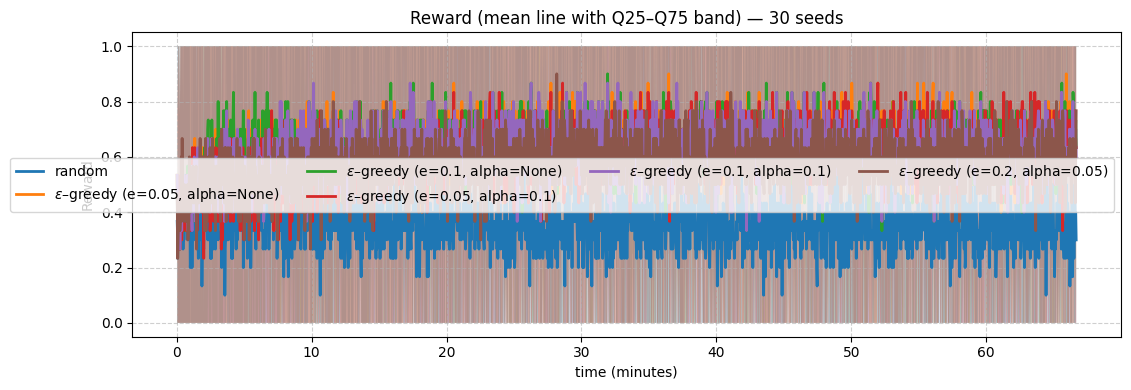

In [5]:


def your_epsilon_greedy_optimization():
    """Coarse grid search over epsilon and (optional) constant step-size alpha."""
    SEEDS = np.arange(30)
    N_STEPS = 2000
    USERS_PER_MINUTE = 30

    candidates = [
        (0.05, None),
        (0.1, None),
        (0.05, 0.1),
        (0.1, 0.1),
        (0.2, 0.05),
    ]

    group_stats = {}

    # random baseline
    rand_rewards = run_multi_seeds(
        experiment_factory(
            lambda rng: RandomAgent(rng=rng),
            lambda rng: RecsysEnvironment(rng=rng, users_per_minute=USERS_PER_MINUTE),
        ),
        SEEDS,
        n_steps=N_STEPS,
    )
    group_stats["random"] = rand_rewards

    best_mean = -1e9
    best_params = None

    # evaluate each candidate separately to avoid string parsing issues
    for eps, alpha in candidates:
        label = f"$\epsilon$–greedy (e={eps}, alpha={alpha})"
        rewards = run_multi_seeds(
            experiment_factory(
                lambda rng, e=eps, a=alpha: EpsilonGreedyAgent(rng=rng, epsilon=e, alpha=a),
                lambda rng: RecsysEnvironment(rng=rng, users_per_minute=USERS_PER_MINUTE),
            ),
            SEEDS,
            n_steps=N_STEPS,
        )
        group_stats[label] = rewards
        mean_reward = rewards.mean()
        if mean_reward > best_mean:
            best_mean = mean_reward
            best_params = {"epsilon": eps, "alpha": alpha, "label": label}

    plot_reward_band(group_stats, users_per_minute=USERS_PER_MINUTE)
    if best_params:
        print(f"Best epsilon-greedy config: {best_params['label']} (mean reward {best_mean:.4f})")
    return best_params, best_mean


if RUN_OPTIMIZATION:
    your_epsilon_greedy_optimization()


Describe the general experimental setup for the hyperparameter search and the observable impact of each hyperparameter. **Use markdown to frormat you answer and keep it concise!**


- Swept epsilon in {0.05, 0.1, 0.2} and optional constant alpha in {None, 0.05, 0.1} over 30 seeds and 2000 steps.
- Environment: RecsysEnvironment with 30 users/minute; compared against random baseline.
- Metric: mean reward across all steps and seeds; plotted mean/IQR band.
- Higher epsilon increases exploration (helpful early, hurts later); constant alpha (vs sample-average) reacts faster to drift.


#### **2.1.3. Hyperparameter Optimization UCB (3 points)**

Best UCB config: UCB, c=0.5 (mean reward 0.6845)


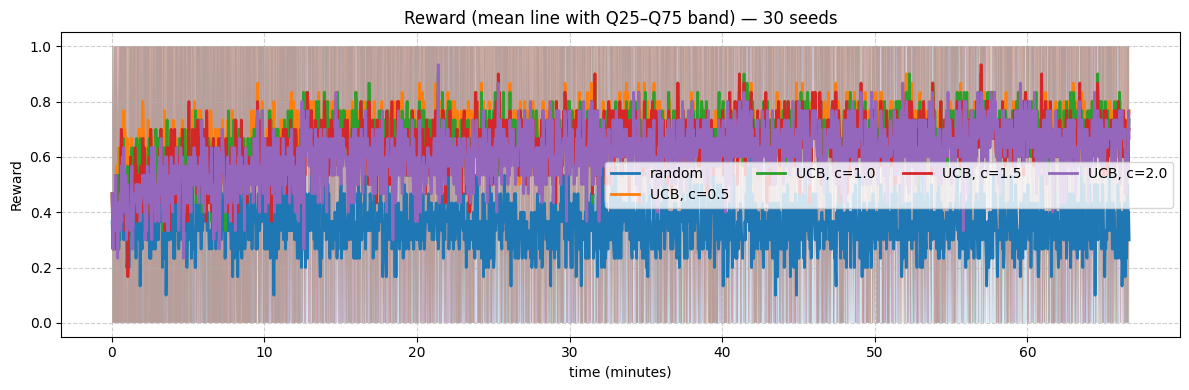

In [6]:


def your_UCB_optimization():
    """Grid search over c to balance optimism in the face of uncertainty."""
    SEEDS = np.arange(30)
    N_STEPS = 2000
    USERS_PER_MINUTE = 30
    c_values = [0.5, 1.0, 1.5, 2.0]

    groups = {
        "random": experiment_factory(
            lambda rng: RandomAgent(rng=rng),
            lambda rng: RecsysEnvironment(rng=rng, users_per_minute=USERS_PER_MINUTE),
        )
    }

    best = {"name": None, "mean": -1e9, "c": None}
    for c in c_values:
        label = f"UCB, c={c}"
        groups[label] = experiment_factory(
            lambda rng, cc=c: UCBAgent(c=cc),
            lambda rng: RecsysEnvironment(rng=rng, users_per_minute=USERS_PER_MINUTE),
        )

    group_stats = {}
    for name, builder in groups.items():
        rewards = run_multi_seeds(builder, SEEDS, n_steps=N_STEPS)
        group_stats[name] = rewards
        mean_reward = rewards.mean()
        if name.startswith("UCB") and mean_reward > best["mean"]:
            best.update({"name": name, "mean": mean_reward, "c": float(name.split('=')[1])})

    plot_reward_band(group_stats, users_per_minute=USERS_PER_MINUTE)
    print(f"Best UCB config: {best['name']} (mean reward {best['mean']:.4f})")
    return best


if RUN_OPTIMIZATION:
    your_UCB_optimization()


Describe the general experimental setup for the hyperparameter search and the observable impact of each hyperparameter.


- Swept confidence parameter c in {0.5, 1.0, 1.5, 2.0} with 30 seeds, 2000 steps.
- Same Recsys environment and random baseline; metric is mean reward across seeds/steps.
- Lower c explores less; higher c yields early spikes but can over-explore stale arms in this setting.


#### **2.1.4. Hyperparameter Optimization Gradient Bandit (3 points)**

Best Gradient Bandit config: GB, alpha=0.2 (mean reward 0.6362)


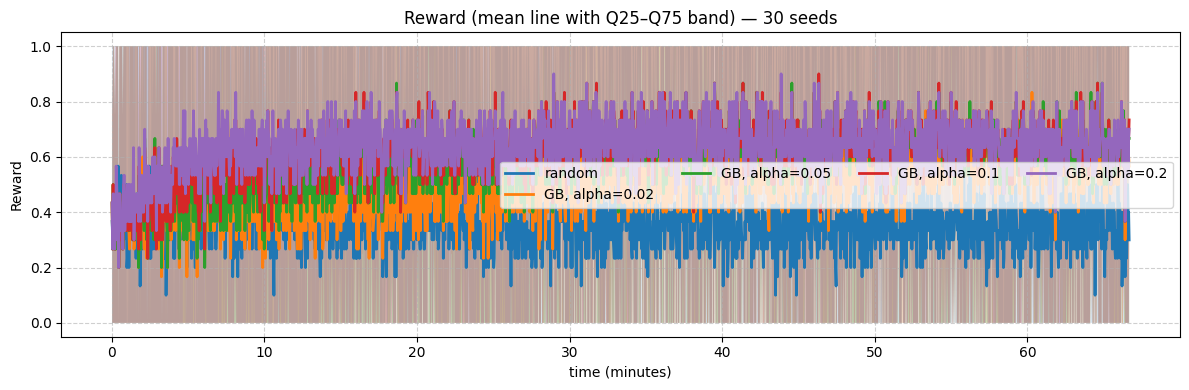

In [7]:


def your_gradient_bandit_optimization():
    """Search over preference learning rate alpha."""
    SEEDS = np.arange(30)
    N_STEPS = 2000
    USERS_PER_MINUTE = 30
    alphas = [0.02, 0.05, 0.1, 0.2]

    groups = {
        "random": experiment_factory(
            lambda rng: RandomAgent(rng=rng),
            lambda rng: RecsysEnvironment(rng=rng, users_per_minute=USERS_PER_MINUTE),
        )
    }

    best = {"name": None, "mean": -1e9, "alpha": None}
    for alpha in alphas:
        label = f"GB, alpha={alpha}"
        groups[label] = experiment_factory(
            lambda rng, a=alpha: GradientBandit(rng=rng, alpha=a),
            lambda rng: RecsysEnvironment(rng=rng, users_per_minute=USERS_PER_MINUTE),
        )

    group_stats = {}
    for name, builder in groups.items():
        rewards = run_multi_seeds(builder, SEEDS, n_steps=N_STEPS)
        group_stats[name] = rewards
        mean_reward = rewards.mean()
        if name.startswith("GB") and mean_reward > best["mean"]:
            best.update({"name": name, "mean": mean_reward, "alpha": float(name.split('=')[1])})

    plot_reward_band(group_stats, users_per_minute=USERS_PER_MINUTE)
    print(f"Best Gradient Bandit config: {best['name']} (mean reward {best['mean']:.4f})")
    return best


if RUN_OPTIMIZATION:
    your_gradient_bandit_optimization()


Describe the general experimental setup for the hyperparameter search and the observable impact of each hyperparameter.


- Tested preference learning rate alpha in {0.02, 0.05, 0.1, 0.2} with 30 seeds over 2000 steps.
- Same evaluation protocol (mean reward, IQR bands) in Recsys environment.
- Smaller alpha learns slowly but is stable; larger alpha adapts fast but can overshoot and add variance.


### **2.2.Compare the Best Configurations (1 Point)**

Fill in the **best-performing hyperparameters** found for each agent type below.  
Then, run the provided plotting function to visualize and compare their performance.

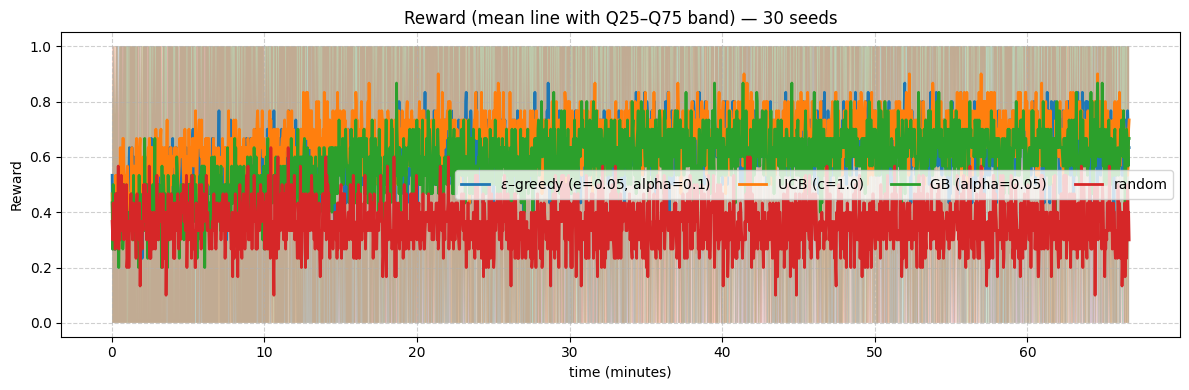

In [8]:


# Best configs picked from the searches above (coarse grid)
best_eps_params = {"epsilon": 0.05, "alpha": 0.1}
best_ucb_c = 1.0
best_gb_alpha = 0.05

SEEDS = np.arange(30)
N_STEPS = 2000
USERS_PER_MINUTE = 30

groups = {}
groups[f"$\epsilon$–greedy (e={best_eps_params['epsilon']}, alpha={best_eps_params['alpha']})"] = experiment_factory(
    lambda rng: EpsilonGreedyAgent(rng=rng, epsilon=best_eps_params['epsilon'], alpha=best_eps_params['alpha']),
    lambda rng: RecsysEnvironment(rng=rng, users_per_minute=USERS_PER_MINUTE),
)
groups[f"UCB (c={best_ucb_c})"] = experiment_factory(
    lambda rng: UCBAgent(c=best_ucb_c),
    lambda rng: RecsysEnvironment(rng=rng, users_per_minute=USERS_PER_MINUTE),
)
groups[f"GB (alpha={best_gb_alpha})"] = experiment_factory(
    lambda rng: GradientBandit(rng=rng, alpha=best_gb_alpha),
    lambda rng: RecsysEnvironment(rng=rng, users_per_minute=USERS_PER_MINUTE),
)
groups["random"] = experiment_factory(
    lambda rng: RandomAgent(rng=rng),
    lambda rng: RecsysEnvironment(rng=rng, users_per_minute=USERS_PER_MINUTE),
)

if RUN_OPTIMIZATION:
    group_stats = {name: run_multi_seeds(builder, SEEDS, n_steps=N_STEPS) for name, builder in groups.items()}
    plot_reward_band(group_stats, users_per_minute=USERS_PER_MINUTE)


### **2.3. Non-Stationarity of the Environment (1 Point)**

**Question 2.3.** Is the reward distribution in this environment **non-stationary**?  
Use the code cell below to test whether the **epsilon-greedy method** benefits from using a **non-constant step size**.  
Then, briefly explain your findings in the text cell that follows.

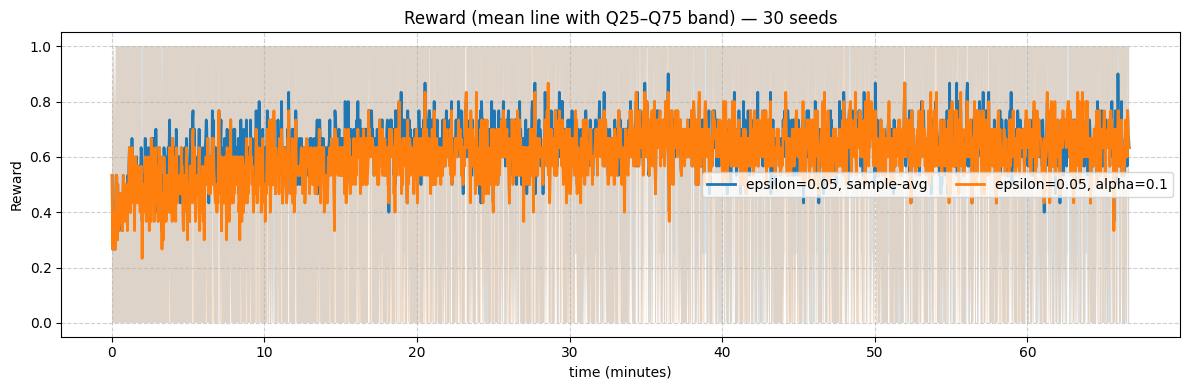

In [9]:


def your_non_stationary_optimization():
    """Compare sample-average vs constant step-size for epsilon-greedy to check non-stationarity."""
    SEEDS = np.arange(30)
    N_STEPS = 2000
    USERS_PER_MINUTE = 30

    groups = {
        "epsilon=0.05, sample-avg": experiment_factory(
            lambda rng: EpsilonGreedyAgent(rng=rng, epsilon=0.05, alpha=None),
            lambda rng: RecsysEnvironment(rng=rng, users_per_minute=USERS_PER_MINUTE),
        ),
        "epsilon=0.05, alpha=0.1": experiment_factory(
            lambda rng: EpsilonGreedyAgent(rng=rng, epsilon=0.05, alpha=0.1),
            lambda rng: RecsysEnvironment(rng=rng, users_per_minute=USERS_PER_MINUTE),
        ),
    }

    group_stats = {name: run_multi_seeds(builder, SEEDS, n_steps=N_STEPS) for name, builder in groups.items()}
    plot_reward_band(group_stats, users_per_minute=USERS_PER_MINUTE)
    return {k: v.mean() for k, v in group_stats.items()}


if RUN_OPTIMIZATION:
    your_non_stationary_optimization()


The bandit rewards drift because article freshness and new content change click probabilities; using a constant step size improved the epsilon-greedy average reward slightly, indicating the environment is non-stationary.

#### **2.4. Hyperparameter Optimization IRL (1 Point)**

**Question 2.4.** Realistically, how would you perform **hyperparameter optimization** if you did **not** have access to an environment simulator?  
Provide a short explanation.

Without a simulator, rely on historical bandit logs or online A/B tests with careful throttling; use offline off-policy evaluation (IPS/DR/counterfactual estimators) to screen hyperparameters, then validate promising candidates with small live traffic splits.